# Petite implémentation d'un RNN tout simple pour tester les fonctions d'importation de la Base de données faites par Tristan

In [62]:
import torch
from random import randint
from utilities import chordUtil
from utilities import dataImport
from utilities.chordUtil import *
from utilities.dataImport import *
from sklearn.model_selection import train_test_split
import os
import numpy as np
import random
import sys
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [63]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [64]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
print("use_cuda")
print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")

use_cuda
False


In [65]:
# Init
lenSeq = 16
alpha = 'a0'
rootname = "inputs/jazz_xlab/"
filenames = os.listdir(rootname)
#filenames.remove(".DS_Store")
dictChord, listChord = chordUtil.getDictChord(eval(alpha))
print(len(dictChord))
print(dictChord)

25
{'D:maj': 0, 'G#:maj': 1, 'B:min': 2, 'C#:maj': 3, 'D#:maj': 4, 'A:min': 5, 'G:maj': 6, 'A#:maj': 7, 'C#:min': 8, 'A#:min': 9, 'G#:min': 10, 'D:min': 11, 'F#:min': 12, 'B:maj': 13, 'F:maj': 14, 'E:min': 15, 'D#:min': 16, 'N': 17, 'C:min': 18, 'E:maj': 19, 'G:min': 20, 'A:maj': 21, 'C:maj': 22, 'F:min': 23, 'F#:maj': 24}


In [66]:
# Create datasets
files_train ,files_test = train_test_split(filenames,test_size=0.7)
dataset_train = dataImport.ChordSeqDataset(files_train, rootname, alpha, dictChord, lenSeq)
dataset_test = dataImport.ChordSeqDataset(files_test, rootname, alpha, dictChord, lenSeq)


In [67]:
# Create generators
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
training_generator = data.DataLoader(dataset_train, **params)
testing_generator = data.DataLoader(dataset_test, **params)


In [78]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=0)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 0)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 0)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.hidden_size)

In [79]:
def train(local_batch, local_labels):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0
    #print(local_batch[0])
    #print(local_batch.size())
    #print(local_labels[0])
    #print(local_labels.size())
    # parcourir le mini batch
    for i in range(len(local_batch)):
        # parcourir la sequence
        for j in range(len(local_batch[i])):      
            output, hidden = rnn(local_batch[i][j], hidden)
            
        #print(output)
        #print(local_labels[i])
        #l = criterion(output, torch.tensor([torch.argmax(local_labels[i])]))
        #l = criterion(output, local_labels[i])
        l = criterion(torch.reshape(output,(1, len(output))), torch.tensor([torch.argmax(local_labels[i])]))
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / len(local_batch)

In [84]:
rnn = RNN(len(dictChord), 128, len(dictChord))

plot_every = 1
all_losses = []
total_loss = 0 # Reset every plot_every iters
start = time.time()
criterion = nn.NLLLoss()
learning_rate = 0.0005
print_every = 5
max_epochs = 100


# Begin training

for epoch in range(1, max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        output, loss = train(local_batch, local_labels)
        total_loss += loss

    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), epoch, epoch / max_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(total_loss / (plot_every * len(local_batch)))
        total_loss = 0
        

    # Testing
    #for local_batch, local_labels in testing_generator:
        # Transfer to GPU
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # //// Test the model  ////


0m 23s (5 5%) 2.9609
0m 47s (10 10%) 2.7607
1m 11s (15 15%) 2.3334
1m 33s (20 20%) 2.1966
1m 56s (25 25%) 2.3618
2m 18s (30 30%) 2.5332
2m 41s (35 35%) 2.4609
3m 4s (40 40%) 1.9367
3m 28s (45 45%) 2.2944
3m 52s (50 50%) 1.5979
4m 14s (55 55%) 1.9669
4m 37s (60 60%) 1.5029
5m 0s (65 65%) 1.4604
5m 23s (70 70%) 1.9983
5m 46s (75 75%) 1.7085
6m 8s (80 80%) 1.9492
6m 31s (85 85%) 1.5951
6m 53s (90 90%) 0.7699
7m 17s (95 95%) 2.2077


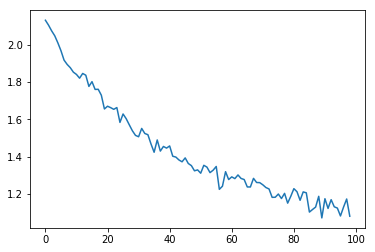

In [85]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [86]:
test_sequence = ["C:maj","F:maj","C:maj","C:maj","F:maj","F:maj","C:maj","C:maj","G:maj","F:maj"]

test_sequence_tensor = torch.zeros(len(test_sequence), len(dictChord))
for t in range(len(test_sequence)):
    test_sequence_tensor[t, dictChord[test_sequence[t]]] = 1


In [87]:
hidden = rnn.initHidden()
generation_lenght = 100

generated_sequence = [0 for i in range(generation_lenght)]

for t in range(generation_lenght):
    if t < len(test_sequence):
        output, hidden = rnn(test_sequence_tensor[t], hidden)
        generated_sequence[t] = test_sequence[t]
    else : 
        last_chord_output = torch.zeros(len(dictChord))
        last_chord_output[torch.argmax(output).item()]
        output, hidden = rnn(last_chord_output, hidden)
        generated_sequence[t] = listChord[torch.argmax(output).item()]

        
for i in range(generation_lenght):
    if i%8 == 0:
        print(generated_sequence[i:i+8])

['C:maj', 'F:maj', 'C:maj', 'C:maj', 'F:maj', 'F:maj', 'C:maj', 'C:maj']
['G:maj', 'F:maj', 'F:maj', 'N', 'N', 'N', 'N', 'N']
['C:maj', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
['C:maj', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
['N', 'N', 'N', 'N', 'N', 'N', 'N', 'C:maj']
['N', 'N', 'C:maj', 'N', 'N', 'N', 'N', 'N']
['N', 'C:maj', 'N', 'N', 'N', 'N', 'N', 'N']
['C:maj', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
['N', 'N', 'N', 'N', 'C:maj', 'N', 'N', 'N']
['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
['N', 'N', 'N', 'N', 'C:maj', 'N', 'C:maj', 'N']
['N', 'N', 'N', 'N']
